**비지도 학습을 활용한 군집, 이상치 탐지, 밀도 추정을 탐구하고 실 데이터셋에 대해 수행 및 분석한다.**

# 설정

먼저 몇 개의 모듈을 임포트한다. 맷플롯립 그림을 저장하는 함수를 준비한다.

In [1]:
# 공통 모듈 임포트
import matplotlib as mpl
import os
import matplotlib.pyplot as plt

# 깔끔한 그래프 출력을 위해
mpl.rc("axes", labelsize=14)
mpl.rc("xtick", labelsize=12)
mpl.rc("ytick", labelsize=12)
# 그림을 저장할 위치
PROJECT_ROOT_DIR = '.'
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)


def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + '.' + fig_extension)
    print(f"그림 저장: {fig_id}")
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 군집

**분류 _vs_ 군집**

In [2]:
from sklearn.datasets import load_iris

data = load_iris()
X = data.data
y = data.target
data.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

그림 저장: classification_vs_clustering_plot


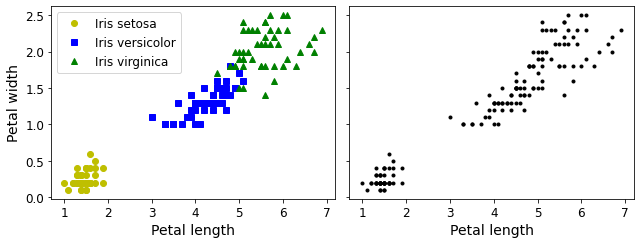

In [3]:
plt.figure(figsize=(9, 3.5))
plt.subplot(121)
plt.plot(X[y == 0, 2], X[y == 0, 3], "yo", label="Iris setosa")
plt.plot(X[y == 1, 2], X[y == 1, 3], "bs", label="Iris versicolor")
plt.plot(X[y == 2, 2], X[y == 2, 3], "g^", label="Iris virginica")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(fontsize=12)
plt.subplot(122)
plt.scatter(X[:, 2], X[:, 3], c='k', marker='.')
plt.xlabel("Petal length", fontsize=14)
plt.tick_params(labelleft=False)
save_fig("classification_vs_clustering_plot")
plt.show()

(아래에서) 가우시안 혼합 모델은 3개의 클러스터를 잘 나눌 수 있다(꽃잎 길이와 너비, 꽃받침 길이와 너비 4개의 특성을 모두 사용한다).

In [4]:
from sklearn.mixture import GaussianMixture

y_pred = GaussianMixture(n_components=3).fit(X).predict(X)

각 클러스터를 하나의 클래스에 매핑해 보자. 이 매핑을 하드 코딩하는 대신 (`scipy.stats.mode()` 함수를 사용해) 각 클러스터에서 가장 많은 클래스를 선택한다:

In [5]:
import numpy as np
from scipy import stats

mapping = {}
for class_id in np.unique(y):
    mode, _ = stats.mode(y_pred[y == class_id])
    mapping[mode[0]] = class_id
mapping

{0: 0, 1: 1, 2: 2}

In [6]:
y_pred = np.array([mapping[cluster_id] for cluster_id in y_pred])

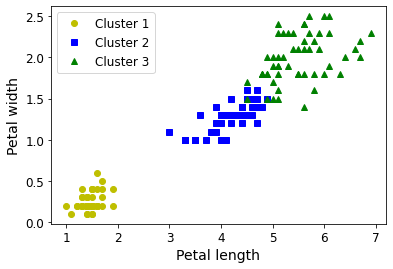

In [7]:
plt.plot(X[y_pred == 0, 2], X[y_pred == 0, 3], "yo", label="Cluster 1")
plt.plot(X[y_pred == 1, 2], X[y_pred == 1, 3], "bs", label="Cluster 2")
plt.plot(X[y_pred == 2, 2], X[y_pred == 2, 3], "g^", label="Cluster 3")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=12)
plt.show()

In [8]:
np.sum(y_pred == y)

145

In [9]:
np.sum(y_pred == y) / len(y_pred)

0.9666666666666667

**노트**: 사이킷런 알고리즘이 이따금 업데이트되기 때문에 이 노트북의 결과가 조금 다를 수 있다.

## K-평균

먼저 예제 데이터를 생성해 보자:

In [10]:
blob_centers = np.array([[0.2, 2.3], [-1.5, 2.3], [-2.8, 1.8], [-2.8, 2.8], [-2.8, 1.3]])
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])

데이터를 그래프로 그린다:

In [11]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=2000, centers=blob_centers, cluster_std=blob_std, random_state=7)

In [12]:
def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)

그림 저장: blobs_plot


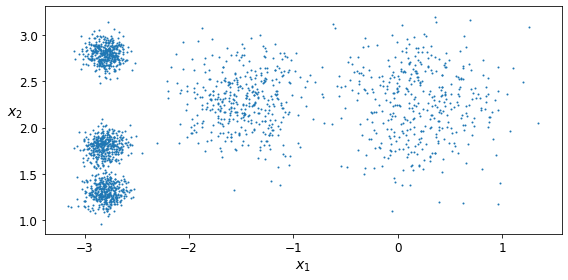

In [13]:
plt.figure(figsize=(8, 4))
plot_clusters(X)
save_fig("blobs_plot")
plt.show()

**훈련과 예측**

이 데이터셋에 K-평균 군집 알고리즘을 훈련해 보겠다. 이 알고리즘은 클러스터 중심을 찾고 각 샘플을 가까운 클러스터에 할당한다:

In [14]:
from sklearn.cluster import KMeans

k = 5
kmeans = KMeans(n_clusters=k)
y_pred = kmeans.fit_predict(X)

각 샘플은 5개의 클러스터 중 하나에 할당된다:

In [15]:
y_pred

array([2, 4, 1, ..., 0, 1, 4])

In [16]:
y_pred is kmeans.labels_

True

5개의 _센트로이드_ (즉 클러스터 중심)을 찾았다:

In [17]:
kmeans.cluster_centers_

array([[-2.79290307,  2.79641063],
       [ 0.20876306,  2.25551336],
       [-2.80037642,  1.30082566],
       [-1.46679593,  2.28585348],
       [-2.80389616,  1.80117999]])

`KMeans` 객체는 훈련한 샘플의 레이블을 가지고 있다. 조금 혼동스럽지만 여기에서 샘플의 _레이블_ 은 샘플에 할당한 클러스터의 인덱스이다:

In [18]:
kmeans.labels_

array([2, 4, 1, ..., 0, 1, 4])

물론 새로운 샘플의 레이블을 예측할 수 있다:

In [19]:
X_new = np.array([[0, 2], [3, 2], [-3, 3], [-3, 2.5]])
kmeans.predict(X_new)

array([1, 1, 0, 0])

**결정 경계**

이 모델의 결정 경계를 그려 보자. 이 그림은 _보로노이 다이어그램_ 이 된다:

In [20]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], "k.", markersize=2)


def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(
        centroids[:, 0], centroids[:, 1], marker='o', s=35, linewidths=8, color=circle_color, zorder=10, alpha=0.9
    )
    plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=2, linewidths=12, color=cross_color, zorder=11, alpha=1)


def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True, show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution), np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]), cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]), linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

그림 저장: voronoi_plot


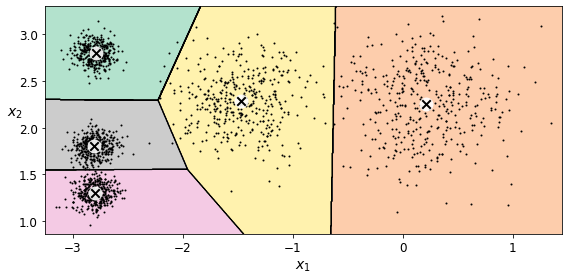

In [21]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X)
save_fig("voronoi_plot")
plt.show()

나쁘지 않군! 경계 근처에 있는 일부 샘플은 아마도 클러스터에 잘못 할당된 것 같다. 하지만 전반적으로 아주 좋은 것 같다.

**하드 군집 _vs_ 소프트 군집**

_하드 군집_ 은 각 샘플에 대해 가장 가까운 클러스터를 선택한다. 이 대신 샘플에서 5개의 센트로이드까지 거리를 측정하는 것이 나을 수 있다. `transform()` 메서드에서 이 거리를 계산한다:

In [22]:
kmeans.transform(X_new)

array([[2.9042344 , 0.32995317, 2.88633901, 1.49439034, 2.81093633],
       [5.84739223, 2.80290755, 5.84236351, 4.4759332 , 5.80730058],
       [0.29040966, 3.29399768, 1.71086031, 1.69136631, 1.21475352],
       [0.36159148, 3.21806371, 1.21567622, 1.54808703, 0.72581411]])

이 거리가 샘플과 센트로이드 사이의 유클리드 거리인지 확인할 수 있다:

In [23]:
np.linalg.norm(np.tile(X_new, (1, k)).reshape(-1, k, 2) - kmeans.cluster_centers_, axis=2)

array([[2.9042344 , 0.32995317, 2.88633901, 1.49439034, 2.81093633],
       [5.84739223, 2.80290755, 5.84236351, 4.4759332 , 5.80730058],
       [0.29040966, 3.29399768, 1.71086031, 1.69136631, 1.21475352],
       [0.36159148, 3.21806371, 1.21567622, 1.54808703, 0.72581411]])

### K-평균 알고리즘

K-평균 알고리즘은 가장 빠르고 가장 간단한 군집 알고리즘 중 하나이다:
* 먼저 $k$ 개의 센트로이드를 랜덤하게 초기화한다: 데이터셋에서 $k$ 개의 샘플을 랜덤하게 선택하고 센트로이드를 그 위치에 놓는다.
* 수렴할 때까지 다음을 반복한다(즉, 센트로이드가 더 이상 이동하지 않을 때까지):
    * 각 샘플을 가장 가까운 센트로이드에 할당한다.
    * 센트로이드에 할당된 샘플의 평균으로 센트로이드를 업데이트한다.

`KMeans` 클래스는 기본적으로 최적화된 알고리즘을 적용한다. 원래 K-평균 알고리즘을 사용하려면 `init="random"`, `n_init=1`로 설정해야 한다.

K-평균 알고리즘을 1, 2, 3회 반복하고 센트로이드가 어떻게 움직이는지 확인해 본다:

In [24]:
kmeans_iter1 = KMeans(n_clusters=5, init="random", n_init=1, max_iter=1, random_state=0)
kmeans_iter2 = KMeans(n_clusters=5, init="random", n_init=1, max_iter=2, random_state=0)
kmeans_iter3 = KMeans(n_clusters=5, init="random", n_init=1, max_iter=3, random_state=0)
kmeans_iter1.fit(X)
kmeans_iter2.fit(X)
kmeans_iter3.fit(X)

KMeans(init='random', max_iter=3, n_clusters=5, n_init=1, random_state=0)

그래프를 그려 본다:

그림 저장: kmeans_algorithm_plot


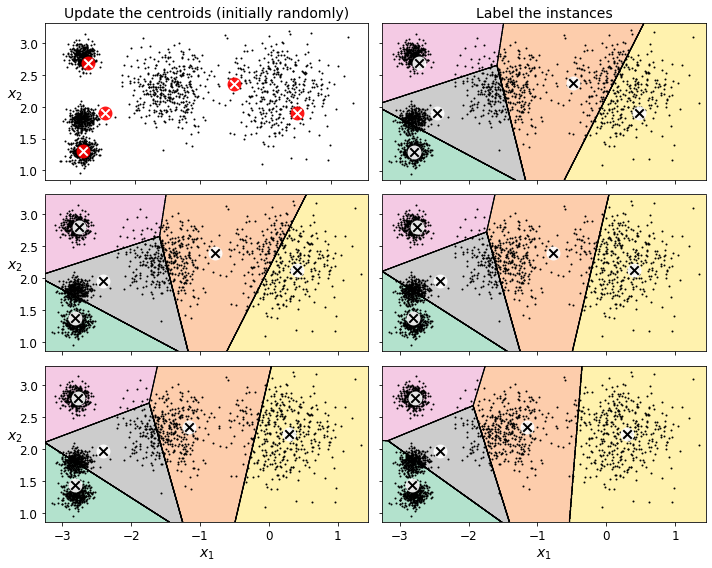

In [25]:
plt.figure(figsize=(10, 8))
plt.subplot(321)
plot_data(X)
plot_centroids(kmeans_iter1.cluster_centers_, circle_color='r', cross_color='w')
plt.ylabel("$x_2$", fontsize=14, rotation=0)
plt.tick_params(labelbottom=False)
plt.title("Update the centroids (initially randomly)", fontsize=14)
plt.subplot(322)
plot_decision_boundaries(kmeans_iter1, X, show_xlabels=False, show_ylabels=False)
plt.title("Label the instances", fontsize=14)
plt.subplot(323)
plot_decision_boundaries(kmeans_iter1, X, show_centroids=False, show_xlabels=False)
plot_centroids(kmeans_iter2.cluster_centers_)
plt.subplot(324)
plot_decision_boundaries(kmeans_iter2, X, show_xlabels=False, show_ylabels=False)
plt.subplot(325)
plot_decision_boundaries(kmeans_iter2, X, show_centroids=False)
plot_centroids(kmeans_iter3.cluster_centers_)
plt.subplot(326)
plot_decision_boundaries(kmeans_iter3, X, show_ylabels=False)
save_fig("kmeans_algorithm_plot")
plt.show()

**K-평균의 변동성**

원래 K-평균 알고리즘에서는 센트로이드가 그냥 랜덤하게 초기화되고 알고리즘은 단순히 한 번씩 반복하여 앞서 본 것처럼 점차 센트로이드를 개선시킵니다.

하지만 이 방식의 문제점은 K-평균을 여러 번 (또는 다른 랜덤 시드로) 실행하면 아래에서 보듯이 매우 다른 결과를 얻게 되는 점이다:

In [26]:
def plot_clusterer_comparison(clusterer1, clusterer2, X, title1=None, title2=None):
    clusterer1.fit(X)
    clusterer2.fit(X)
    plt.figure(figsize=(10, 3.2))
    plt.subplot(121)
    plot_decision_boundaries(clusterer1, X)
    if title1:
        plt.title(title1, fontsize=14)
    plt.subplot(122)
    plot_decision_boundaries(clusterer2, X, show_ylabels=False)
    if title2:
        plt.title(title2, fontsize=14)

그림 저장: kmeans_variability_plot


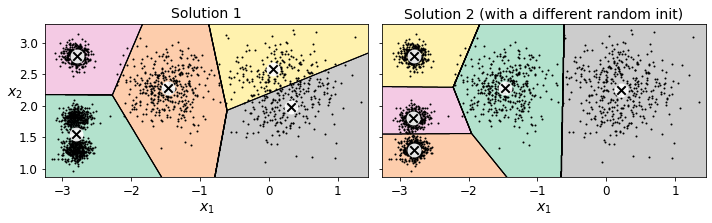

In [27]:
kmeans_rnd_init1 = KMeans(n_clusters=5, init="random", n_init=1, random_state=2)
kmeans_rnd_init2 = KMeans(n_clusters=5, init="random", n_init=1, random_state=5)
plot_clusterer_comparison(
    kmeans_rnd_init1, kmeans_rnd_init2, X, "Solution 1", "Solution 2 (with a different random init)"
)
save_fig("kmeans_variability_plot")
plt.show()

### 이너셔

최선의 모델을 선택하려면 K-평균 모델의 성능을 평가할 방법이 있어야 한다. 안타깝지만 군집은 비지도 학습이기 때문에 타깃이 없다. 하지만 적어도 각 샘플과 센트로이드 사이의 거리는 측정할 수 있다. 이것이 _이너셔_ 지표의 아이디어이다:

In [28]:
kmeans.inertia_

211.59853725816836

이너셔는 각 훈련 샘플과 가장 가까운 센트로이드 사이의 제곱 거리의 합으로 쉽게 검증할 수 있다:

In [29]:
X_dist = kmeans.transform(X)
np.sum(X_dist[np.arange(len(X_dist)), kmeans.labels_] ** 2)

211.59853725816856

`score()` 메서드는 음의 이너셔를 반환한다. 왜 음수일까? 사이킷런의 `score()` 메서드는 항상 " _큰 값이 좋은 것_ " 규칙을 따라야 하기 때문이다.

In [30]:
kmeans.score(X)

-211.59853725816834

### 다중 초기화

변동성 이슈를 해결하는 한 방법은 단순히 K-평균 알고리즘을 랜덤 초기화를 다르게 하여 여러 번 실행하고 가장 작은 이너셔를 만드는 솔루션을 선택하는 방법이다. 예를 들어 앞선 그림에 있는 엉터리 모델 두 개의 이너셔는 다음과 같다.

In [31]:
kmeans_rnd_init1.inertia_

219.43539442771407

In [32]:
kmeans_rnd_init2.inertia_

211.59853725816836

여기서 볼 수 있듯이 앞서 훈련한 "좋은" 모델보다 이너셔가 더 높다. 즉 더 나쁘다는 것을 의미한다.

`n_init` 매개변수를 지정하면 사이킷런은 원래 알고리즘을 `n_init` 번 실행하고 이너셔가 가장 작은 솔루션을 선택한다. 이 매개변수의 기본값은 `n_init=10`이다.

In [33]:
kmeans_rnd_10_inits = KMeans(n_clusters=5, init="random")
kmeans_rnd_10_inits.fit(X)

KMeans(init='random', n_clusters=5)

여기에서 볼 수 있듯이 결국 처음 만들었던 모델을 얻었다. 이 모델이 최적의 K-평균 결과로 보인다($k=5$라고 가정하고 이너셔를 기준으로 했을 때이다).

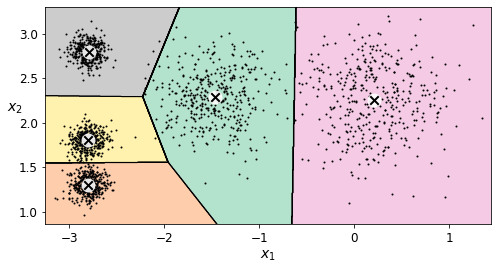

In [34]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans_rnd_10_inits, X)
plt.show()

### 센트로이드 초기화 방법

센트로이드를 완전히 랜덤하게 초기화하는 대신 David Arthur와 Sergei Vassilvitskii가 [2006년 논문](https://goo.gl/eNUPw6)에서 제안한 다음 알고리즘을 사용해 초기화하는 것이 더 좋다:
* 데이터셋에서 무작위로 균등하게 하나의 센트로이드 $c_1$을 선택한다.
* $D(\mathbf{x}_i)^2$ / $\sum\limits_{j=1}^{m}{D(\mathbf{x}_j)}^2$의 확률로 샘플 $\mathbf{x}_i$를 새로운 센트로이드 $c_i$로 선택한다. 여기에서 $D(\mathbf{x}_i)$는 샘플 $\mathbf{x}_i$에서 이미 선택된 가장 가까운 센트로이드까지 거리이다. 이 확률 분포는 이미 선택한 센트로이드에서 멀리 떨어진 샘플을 센트로이드로 선택할 가능성을 높인다.
* $k$ 개의 센트로이드를 선택할 때까지 이전 단계를 반복한다.

K-평균++ 알고리즘의 나머지는 일반 K-평균과 같다. 이 초기화 방식을 사용하면 K-평균 알고리즘이 최적의 솔루션에 수렴할 가능성이 훨씬 높아진다. 따라서 `n_init` 값을 상당히 줄일 수 있다. 대부분의 경우 `n_init`를 줄이는 것이 초기화 과정에 추가된 복잡도를 보상한다.

K-평균++ 초기화를 사용하려면 간단하게 `init="k-means++"`로 지정하면 된다(사실 이 값이 기본값이다):

In [35]:
KMeans()

KMeans()

In [36]:
good_init = np.array([[-3, 3], [-3, 2], [-3, 1], [-1, 2], [0, 2]])
kmeans = KMeans(n_clusters=5, init=good_init, n_init=1)
kmeans.fit(X)
kmeans.inertia_

211.59853725816836

### K-평균 속도 개선

K-평균 알고리즘은 불필요한 거리 계산을 많이 피하는 식으로 속도를 크게 높일 수 있다. 이를 위해 삼각 부등식을 사용한다(3개의 포인트 A, B, C가 있을 때, 거리 AC는 항상 AC ≤ AB + BC를 만족한다). 그리고 샘플과 센트로이드 사이 거리의 최솟값과 최댓값을 유지한다(더 자세한 내용은 Charles Elkan의 [2003년 논문](https://www.aaai.org/Papers/ICML/2003/ICML03-022.pdf)을 참고하자).

Elkan의 K-평균 방식을 사용하려면 `algorithm="elkan"`으로 설정한다. 이 방법은 희소 행렬을 지원하지 않는다. 따라서 사이킷런은 밀집 배열에는 `"elkan"`을 사용하고 희소 행렬에는 (기본 K-평균 알고리즘인) `"lloyd"`을 사용한다.

In [37]:
%timeit -n 50 KMeans(algorithm="elkan").fit(X)

83.2 ms ± 1.95 ms per loop (mean ± std. dev. of 7 runs, 50 loops each)


In [38]:
%timeit -n 50 KMeans().fit(X)

60 ms ± 2.61 ms per loop (mean ± std. dev. of 7 runs, 50 loops each)


데이터셋이 작기 때문에 여기에서는 lloyd 알고리즘이 더 빠르다.

### 미니배치 K-평균

사이킷런은 미니배치를 지원하는 K-평균 방식도 제공한다(이 [논문](http://www.eecs.tufts.edu/~dsculley/papers/fastkmeans.pdf) 참조):

In [39]:
from sklearn.cluster import MiniBatchKMeans

minibatch_kmeans = MiniBatchKMeans(n_clusters=5)
minibatch_kmeans.fit(X)

MiniBatchKMeans(n_clusters=5)

In [40]:
minibatch_kmeans.inertia_

211.62627312496124

데이터셋이 메모리에 다 들어가지 못하면 가장 간단한 방법은 이전 장의 점진적 PCA에서 했던 것처럼 `memmap` 클래스를 사용하는 것이다. 먼저 MNIST 데이터를 로드한다:

In [41]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml("mnist_784", version=1)
mnist.target = mnist.target.astype(np.int64)

In [42]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(mnist["data"], mnist["target"])

`memmap`에 데이터를 기록한다:

In [43]:
filename = "my_mnist.data"
X_mm = np.memmap(filename, dtype="float32", mode="write", shape=X_train.shape)
X_mm[:] = X_train

In [44]:
minibatch_kmeans = MiniBatchKMeans(n_clusters=10, batch_size=10)
minibatch_kmeans.fit(X_mm)

MiniBatchKMeans(batch_size=10, n_clusters=10)

데이터가 너무 커서 `memmap`을 사용할 수 없다면 문제는 더 복잡해진다. 배치를 로드하는 함수를 먼저 만들어 본다(실전에서는 디스크에서 데이터를 로드한다):

In [45]:
def load_next_batch(batch_size):
    return X[np.random.choice(len(X), batch_size, replace=False)]

한 번에 하나의 배치를 모델에 주입하여 훈련할 수 있다. 또한 여러 번 초기화를 수행하고 이너셔가 가장 낮은 모델을 선택한다:

In [46]:
k = 5
n_init = 10
n_iterations = 100
batch_size = 100
init_size = 500  # K-Means++ 초기화를 위해 충분한 데이터 전달
evaluate_on_last_n_iters = 10
best_kmeans = None
for init in range(n_init):
    minibatch_kmeans = MiniBatchKMeans(n_clusters=k, init_size=init_size)
    X_init = load_next_batch(init_size)
    minibatch_kmeans.partial_fit(X_init)
    minibatch_kmeans.sum_inertia_ = 0
    for iteration in range(n_iterations):
        X_batch = load_next_batch(batch_size)
        minibatch_kmeans.partial_fit(X_batch)
        if iteration >= n_iterations - evaluate_on_last_n_iters:
            minibatch_kmeans.sum_inertia_ += minibatch_kmeans.inertia_
    if best_kmeans is None or minibatch_kmeans.sum_inertia_ < best_kmeans.sum_inertia_:
        best_kmeans = minibatch_kmeans

In [47]:
best_kmeans.score(X)

-220.9960784369606

일반적으로 미니배치 K-평균이 일반 K-평균보다 훨씬 빠르지만 다음의 경우엔 데이터셋 크기가 작아 느리게 측정된다:

In [48]:
%timeit KMeans(n_clusters=5).fit(X)

43.6 ms ± 832 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [49]:
%timeit MiniBatchKMeans(n_clusters=5).fit(X)

51.6 ms ± 2.46 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


미니배치 K-평균의 성능이 낮은 (즉 이너셔가 높은) 경우가 많다. _k_ 가 증가할수록 더 그렇다. 미니배치 K-평균과 일반 K-평균 사이에 이너셔와 훈련 시간을 그래프로 나타내 보겠다:

In [50]:
from timeit import timeit

times = np.empty((100, 2))
inertias = np.empty((100, 2))
for k in range(1, 101):
    kmeans_ = KMeans(n_clusters=k)
    minibatch_kmeans = MiniBatchKMeans(n_clusters=k)
    print(f"\r{k}/{100}", end='')
    times[k - 1, 0] = timeit("kmeans_.fit(X)", number=10, globals=globals())
    times[k - 1, 1] = timeit("minibatch_kmeans.fit(X)", number=10, globals=globals())
    inertias[k - 1, 0] = kmeans_.inertia_
    inertias[k - 1, 1] = minibatch_kmeans.inertia_

100/100

그림 저장: minibatch_kmeans_vs_kmeans


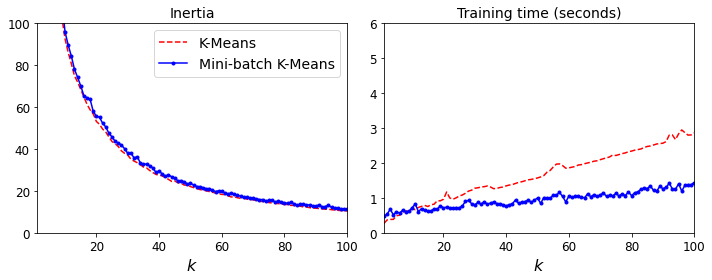

In [51]:
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.plot(range(1, 101), inertias[:, 0], "r--", label="K-Means")
plt.plot(range(1, 101), inertias[:, 1], "b.-", label="Mini-batch K-Means")
plt.xlabel("$k$", fontsize=16)
plt.title("Inertia", fontsize=14)
plt.legend(fontsize=14)
plt.axis([1, 100, 0, 100])
plt.subplot(122)
plt.plot(range(1, 101), times[:, 0], "r--", label="K-Means")
plt.plot(range(1, 101), times[:, 1], "b.-", label="Mini-batch K-Means")
plt.xlabel("$k$", fontsize=16)
plt.title("Training time (seconds)", fontsize=14)
plt.axis([1, 100, 0, 6])
save_fig("minibatch_kmeans_vs_kmeans")
plt.show()

### 최적의 클러스터 개수 찾기

클러스터 개수가 5보다 작거나 크게 지정하면 어떨까?

그림 저장: bad_n_clusters_plot


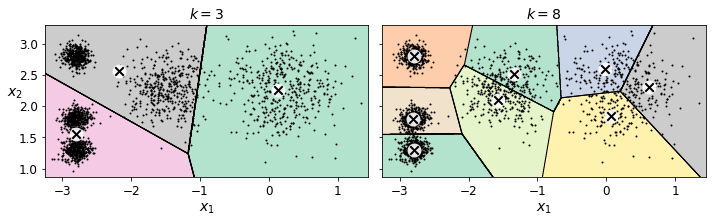

In [52]:
kmeans_k3 = KMeans(n_clusters=3)
kmeans_k8 = KMeans()
plot_clusterer_comparison(kmeans_k3, kmeans_k8, X, "$k=3$", "$k=8$")
save_fig("bad_n_clusters_plot")
plt.show()

두 모델 모두 좋아 보이지 않는다. 이너셔는 어떨까?

In [53]:
kmeans_k3.inertia_

653.2167190021554

In [54]:
kmeans_k8.inertia_

118.42903321656463

$k$가 증가할수록 이너셔가 줄어들기 때문에 단순히 이너셔가 작은 $k$를 선택할 수 없다. 실제 클러스터가 많을수록 샘플은 인접한 센트로이드에 더 가깝다. 따라서 이너셔가 더 작다. 하지만 $k$에 대한 이너셔를 그래프로 그리고 결과 그래프를 조사해 볼 수 있다:

In [55]:
kmeans_per_k = [KMeans(n_clusters=k).fit(X) for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

그림 저장: inertia_vs_k_plot


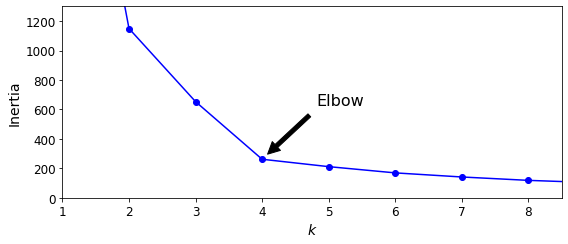

In [56]:
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate(
    "Elbow",
    xy=(4, inertias[3]),
    xytext=(0.55, 0.55),
    textcoords="figure fraction",
    fontsize=16,
    arrowprops=dict(facecolor="black", shrink=0.1)
)
plt.axis([1, 8.5, 0, 1300])
save_fig("inertia_vs_k_plot")
plt.show()

여기에서 볼 수 있듯이 $k=4$에서 엘보우가 있다. 이 값보다 클러스터가 작으면 나쁘다는 뜻이다. 이보다 더 많으면 크게 도움이 되지 않고 배로 늘려도 그렇다. 따라서 $k=4$가 아주 좋은 선택이다. 물론 이 예제에서는 이 값이 완벽하지 않다. 왼쪽 아래 두 클러스터가 하나의 클러스터로 간주되었지만 꽤 좋은 군집 결과이다.

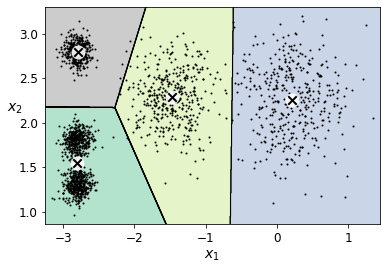

In [57]:
plot_decision_boundaries(kmeans_per_k[4 - 1], X)
plt.show()

또 다른 방법은 모든 샘플에 대한 _실루엣 계수_ 의 평균인 _실루엣 점수_ 이다. 한 샘플의 실루엣 계수는 $(b - a)/\max(a, b)$이다. 여기에서 $a$는 같은 클러스터에 있는 다른 샘플까지의 평균 거리이다(이를 _클러스터 내부 평균 거리_ 라고 한다). $b$는 가장 가까운 클러스터까지 평균 거리이다. 즉 가장 가까운 클러스터(샘플 자신의 클러스터를 제외하고 $b$를 최소화하는 클러스터)의 샘플까지 평균 거리이다. 실루엣 계수는 -1에서 +1 사이 값을 가진다. +1에 가까우면 샘플이 다른 클러스터로부터 떨어져 자신의 클러스터 안에 잘 있다는 것을 의미한다. 0에 가까우면 클러스터 경계에 가깝다는 의미이다. -1에 가까우면 샘플이 잘못된 클러스터에 할당되었을지 모른다.

$k$에 대한 실루엣 점수를 그래프로 그려 보자:

In [58]:
from sklearn.metrics import silhouette_score

silhouette_score(X, kmeans.labels_)

0.655517642572828

In [59]:
silhouette_scores = [silhouette_score(X, model.labels_) for model in kmeans_per_k[1:]]

그림 저장: silhouette_score_vs_k_plot


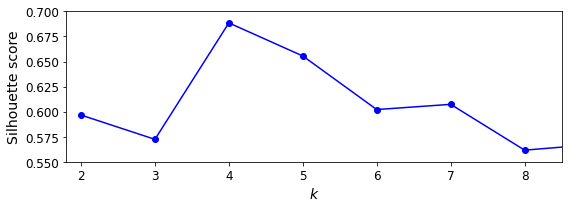

In [60]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.axis([1.8, 8.5, 0.55, 0.7])
save_fig("silhouette_score_vs_k_plot")
plt.show()

여기에서 볼 수 있듯이 이 그래프는 이전보다 정보가 더 풍부하다. 특히 $k=4$가 매우 좋은 선택이지만 $k=5$도 꽤 괜찮은 선택이라는 것을 보여 준다.

모든 샘플의 실루엣 계수를 할당된 클러스터와 실루엣 값으로 정렬하여 그리면 훨씬 많은 정보를 얻을 수 있다. 이를 _실루엣 다이어그램_ 이라고 한다:

그림 저장: silhouette_analysis_plot


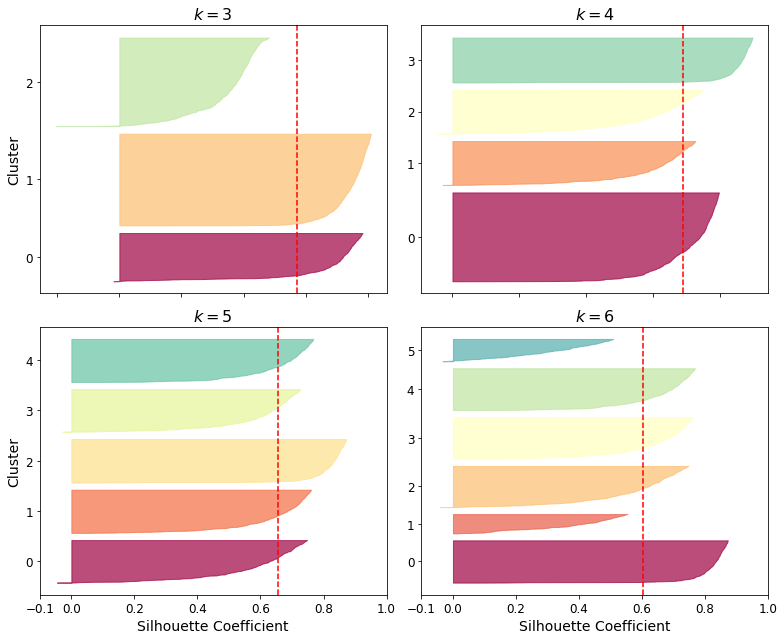

In [61]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(11, 9))
for k in (3, 4, 5, 6):
    plt.subplot(2, 2, k - 2)
    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X, y_pred)
    padding = len(X) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()
        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs, facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding
    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)
    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title(f"$k={k}$", fontsize=16)
save_fig("silhouette_analysis_plot")
plt.show()

여기에서 볼 수 있듯이 $k=5$가 가장 좋은 선택이다. 모든 클러스터의 크기가 거의 동일하고 평균 실루엣 점수를 나타내는 파선을 모두 넘었다.

## K-평균의 한계

In [62]:
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

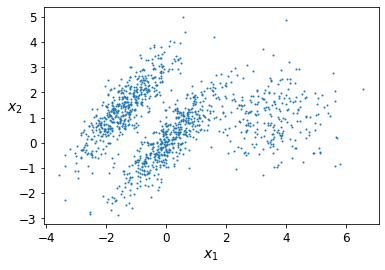

In [63]:
plot_clusters(X)

In [64]:
kmeans_good = KMeans(n_clusters=3, init=np.array([[-1.5, 2.5], [0.5, 0], [4, 0]]), n_init=1, random_state=42)
kmeans_bad = KMeans(n_clusters=3, random_state=42)
kmeans_good.fit(X)
kmeans_bad.fit(X)

KMeans(n_clusters=3, random_state=42)

그림 저장: bad_kmeans_plot


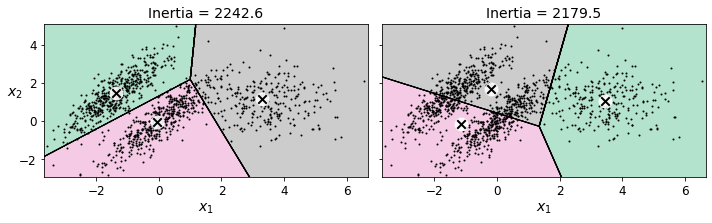

In [65]:
plt.figure(figsize=(10, 3.2))
plt.subplot(121)
plot_decision_boundaries(kmeans_good, X)
plt.title(f"Inertia = {kmeans_good.inertia_:.1f}", fontsize=14)
plt.subplot(122)
plot_decision_boundaries(kmeans_bad, X, show_ylabels=False)
plt.title(f"Inertia = {kmeans_bad.inertia_:.1f}", fontsize=14)
save_fig("bad_kmeans_plot")
plt.show()

## 군집을 사용한 이미지 분할

In [66]:
images_path = os.path.join(PROJECT_ROOT_DIR, "images")
filename = "ladybug.png"

In [67]:
from matplotlib.image import imread

image = imread(os.path.join(images_path, filename))
image.shape

(533, 800, 3)

In [68]:
X = image.reshape(-1, 3)
kmeans = KMeans().fit(X)
segmented_img = kmeans.cluster_centers_[kmeans.labels_]
segmented_img = segmented_img.reshape(image.shape)

In [69]:
segmented_imgs = []
n_colors = (10, 8, 6, 4, 2)
for n_clusters in n_colors:
    kmeans = KMeans(n_clusters=n_clusters).fit(X)
    segmented_img = kmeans.cluster_centers_[kmeans.labels_]
    segmented_imgs.append(segmented_img.reshape(image.shape))

그림 저장: image_segmentation_diagram


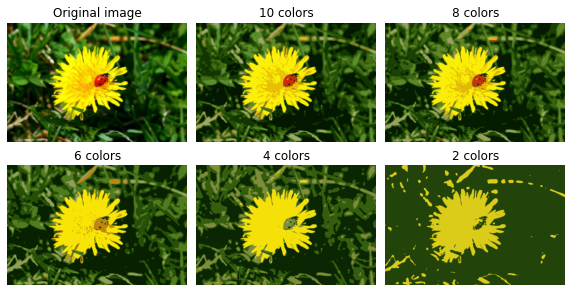

In [70]:
plt.figure(figsize=(10, 5))
plt.subplots_adjust(wspace=0.05, hspace=0.1)
plt.subplot(231)
plt.imshow(image)
plt.title("Original image")
plt.axis('off')
for idx, n_clusters in enumerate(n_colors):
    plt.subplot(232 + idx)
    plt.imshow(segmented_imgs[idx])
    plt.title(f"{n_clusters} colors")
    plt.axis('off')
save_fig('image_segmentation_diagram', tight_layout=False)
plt.show()

## 군집을 사용한 전처리

MNIST와 유사하게 숫자 0에서 9까지 8x8 흑백 이미지 1,797개로 이루어진 _숫자 데이터셋_ 을 다루어 보겠다.

In [71]:
from sklearn.datasets import load_digits

X_digits, y_digits = load_digits(return_X_y=True)

훈련 세트와 테스트 세트로 나눈다:

In [72]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_digits, y_digits, random_state=42)

In [73]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(multi_class="ovr", max_iter=5000, n_jobs=-1)
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=5000, multi_class='ovr', n_jobs=-1)

In [74]:
log_reg_score = log_reg.score(X_test, y_test)
log_reg_score

0.9688888888888889

좋다. 기본 모델의 정확도이다. 이제 K-평균을 전처리 단계로 사용해 더 향상할 수 있는지 알아 본다. 훈련 세트를 50개의 클러스터로 만들고 이미지를 이 클러스터까지 거리로 바꾼 다음 로지스틱 회귀 모델을 적용하는 파이프라인을 만든다:

In [75]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline(
    [("kmeans", KMeans(n_clusters=50)), ("log_reg", LogisticRegression(multi_class="ovr", max_iter=5000, n_jobs=-1))]
)
pipeline.fit(X_train, y_train)

Pipeline(steps=[('kmeans', KMeans(n_clusters=50)),
                ('log_reg',
                 LogisticRegression(max_iter=5000, multi_class='ovr',
                                    n_jobs=-1))])

In [76]:
pipeline_score = pipeline.score(X_test, y_test)
pipeline_score

0.98

얼마나 오차가 감소했을까?

In [77]:
1 - (1 - pipeline_score) / (1 - log_reg_score)

0.3571428571428561

어떤가? 오차율을 줄였다! 하지만 클러스터 개수 $k$를 임의로 결정했다. 이 보다 더 나은 방법이 있을 것이다. K-평균을 분류 파이프라인에서 전처리 단계로 사용했기 때문에 좋은 $k$ 값을 찾는 것은 이전보다 더 쉽다. 실루엣 분석을 수행하거나 이너셔를 최소화할 필요가 없다. 가장 좋은 $k$ 값은 가장 좋은 분류 성능을 내는 것이다.

**경고**: 사용하는 하드웨어에 따라 다음 셀을 실행하는데 20분 또는 그 이상 걸릴 수 있다.

In [78]:
from sklearn.model_selection import GridSearchCV

param_grid = dict(kmeans__n_clusters=range(2, 100))
grid_clf = GridSearchCV(pipeline, param_grid, cv=3, verbose=2, n_jobs=-1)
grid_clf.fit(X_train, y_train)

Fitting 3 folds for each of 98 candidates, totalling 294 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kmeans', KMeans(n_clusters=50)),
                                       ('log_reg',
                                        LogisticRegression(max_iter=5000,
                                                           multi_class='ovr',
                                                           n_jobs=-1))]),
             n_jobs=-1, param_grid={'kmeans__n_clusters': range(2, 100)},
             verbose=2)

최고의 클러스터 개수를 확인해 본다:

In [79]:
grid_clf.best_params_

{'kmeans__n_clusters': 65}

In [80]:
grid_clf.score(X_test, y_test)

0.9844444444444445

## 군집을 사용한 준지도 학습

군집의 또 다른 사용처는 레이블이 없는 샘플이 많고 레이블이 있는 샘플이 적을 때 사용하는 준지도 학습이다.

레이블을 가진 샘플이 50개만 있을 때 로지스틱 회귀 모델의 성능을 확인해 보자:

In [81]:
n_labeled = 50

In [82]:
log_reg = LogisticRegression(multi_class="ovr", n_jobs=-1)
log_reg.fit(X_train[:n_labeled], y_train[:n_labeled])
log_reg.score(X_test, y_test)

0.8333333333333334

당연히 이전보다 훨씬 낮다. 어떻게 더 향상할 수 있는지 알아 보자. 먼저 훈련 세트를 클러스터 50개로 군집한다. 그다음 각 클러스터에서 센트로이드에 가장 가까운 이미지를 찾는다. 이 이미지를 대표 이미지라고 부르겠다:

In [83]:
k = 50

In [84]:
kmeans = KMeans(n_clusters=k, random_state=42)
X_digits_dist = kmeans.fit_transform(X_train)
representative_digit_idx = np.argmin(X_digits_dist, axis=0)
X_representative_digits = X_train[representative_digit_idx]

대표 이미지를 출력하고 수동으로 레이블을 매겨 보겠다:

그림 저장: representative_images_diagram


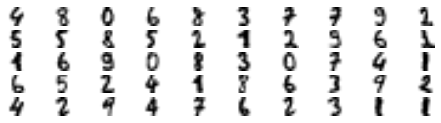

In [85]:
plt.figure(figsize=(8, 2))
for index, X_representative_digit in enumerate(X_representative_digits):
    plt.subplot(k // 10, 10, index + 1)
    plt.imshow(X_representative_digit.reshape(8, 8), cmap="binary", interpolation="bilinear")
    plt.axis('off')
save_fig("representative_images_diagram", tight_layout=False)
plt.show()

In [86]:
y_train[representative_digit_idx]

array([4, 8, 0, 6, 8, 3, 7, 7, 9, 2, 5, 5, 8, 5, 2, 1, 2, 9, 6, 1, 1, 6,
       9, 0, 8, 3, 0, 7, 4, 1, 6, 5, 2, 4, 1, 8, 6, 3, 9, 2, 4, 2, 9, 4,
       7, 6, 2, 3, 1, 1])

In [87]:
y_representative_digits = np.array(
    [
        4, 8, 0, 6, 8, 3, 7, 7, 9, 2, 5, 5, 8, 5, 2, 1, 2, 9, 6, 1, 1, 6,
        9, 0, 8, 3, 0, 7, 4, 1, 6, 5, 2, 4, 1, 8, 6, 3, 9, 2, 4, 2, 9, 4,
        7, 6, 2, 3, 1, 1
    ]
)

이 데이터셋은 레이블이 있는 샘플이 50개뿐이지만 완전히 랜덤한 샘플이 아니라 각 샘플은 클러스터의 대표 이미지이다. 성능이 더 나은지 확인해 보자:

In [88]:
log_reg = LogisticRegression(multi_class="ovr", max_iter=5000, n_jobs=-1)
log_reg.fit(X_representative_digits, y_representative_digits)
log_reg.score(X_test, y_test)

0.9222222222222223

와우! 확 올랐다. 여전히 50개의 샘플로만 모델을 훈련했다. 샘플에 레이블을 다는 것은 비용이 많이 들고 어려운 작업이다. 특히 전문가가 수동으로 작업할 때 그렇다. 이 때 랜덤한 샘플보다는 대표 샘플에 레이블을 다는 것이 좋은 생각이다.

하지만 더 향상시킬 수 있다. 이 레이블을 같은 클러스터에 있는 다른 모든 샘플에 전파하면 어떨까?

In [89]:
y_train_propagated = np.empty(len(X_train), dtype=np.int32)
for i in range(k):
    y_train_propagated[kmeans.labels_ == i] = y_representative_digits[i]

In [90]:
log_reg = LogisticRegression(multi_class="ovr", max_iter=5000, n_jobs=-1)
log_reg.fit(X_train, y_train_propagated)

LogisticRegression(max_iter=5000, multi_class='ovr', n_jobs=-1)

In [91]:
log_reg.score(X_test, y_test)

0.9333333333333333

아주 조금 정확도를 높였다. 없는 것보다는 낫지만 센트로이드에 가까운 샘플에만 레이블을 전파하는 것이 나을지 모른다. 왜냐하면 전체 클러스터에 전파하면 일부 이상치를 포함하기 때문이다. 레이블을 센트로이드에 가까운 75번째 백분위수까지만 전파해 보자:

In [92]:
percentile_closest = 75
X_cluster_dist = X_digits_dist[np.arange(len(X_train)), kmeans.labels_]
for i in range(k):
    in_cluster = (kmeans.labels_ == i)
    cluster_dist = X_cluster_dist[in_cluster]
    cutoff_distance = np.percentile(cluster_dist, percentile_closest)
    above_cutoff = (X_cluster_dist > cutoff_distance)
    X_cluster_dist[in_cluster & above_cutoff] = -1

In [93]:
partially_propagated = (X_cluster_dist != -1)
X_train_partially_propagated = X_train[partially_propagated]
y_train_partially_propagated = y_train_propagated[partially_propagated]

In [94]:
log_reg = LogisticRegression(multi_class="ovr", max_iter=5000, n_jobs=-1)
log_reg.fit(X_train_partially_propagated, y_train_partially_propagated)

LogisticRegression(max_iter=5000, multi_class='ovr', n_jobs=-1)

In [95]:
log_reg.score(X_test, y_test)

0.9355555555555556

조금 더 낫다. 레이블된 샘플 50개(클래스당 평균 5개 샘플!)만 가지고 달성했다. 레이블된 전체 숫자 데이터셋에서 훈련한 로지스틱 회귀의 성능과 매우 비슷하다.

이는 전파된 레이블이 실제로 매우 좋기 때문이다:

In [96]:
np.mean(y_train_partially_propagated == y_train[partially_propagated])

0.9750747756729811

*능동 학습*을 여러 번 반복할 수 있다:
1. 분류기의 확신이 부족한 샘플에 수동으로 레이블을 부여한다. 가능하면 다른 클러스터에서 샘플을 선택한다.
2. 추가된 레이블을 사용해 새로운 모델을 훈련한다.

## DBSCAN

In [97]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=1000, noise=0.05)

In [98]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.05, n_jobs=-1)
dbscan.fit(X)

DBSCAN(eps=0.05, n_jobs=-1)

In [99]:
dbscan.labels_[:10]

array([-1,  0,  1,  2,  3,  1,  2,  3,  2,  4], dtype=int64)

In [100]:
len(dbscan.core_sample_indices_)

777

In [101]:
dbscan.core_sample_indices_[:10]

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int64)

In [102]:
dbscan.components_[:3]

array([[0.83612339, 0.49945971],
       [0.1092696 , 1.03274653],
       [1.9339695 , 0.05246871]])

In [103]:
np.unique(dbscan.labels_)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9], dtype=int64)

In [104]:
dbscan2 = DBSCAN(eps=0.2, n_jobs=-1)
dbscan2.fit(X)

DBSCAN(eps=0.2, n_jobs=-1)

In [105]:
def plot_dbscan(dbscan, X, size, show_xlabels=True, show_ylabels=True):
    core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_mask[dbscan.core_sample_indices_] = True
    anomalies_mask = dbscan.labels_ == -1
    non_core_mask = ~(core_mask | anomalies_mask)
    cores = dbscan.components_
    anomalies = X[anomalies_mask]
    non_cores = X[non_core_mask]
    plt.scatter(cores[:, 0], cores[:, 1], c=dbscan.labels_[core_mask], marker='o', s=size, cmap="Paired")
    plt.scatter(cores[:, 0], cores[:, 1], marker='*', s=20, c=dbscan.labels_[core_mask])
    plt.scatter(anomalies[:, 0], anomalies[:, 1], c='r', marker='x', s=100)
    plt.scatter(non_cores[:, 0], non_cores[:, 1], c=dbscan.labels_[non_core_mask], marker='.')
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title(f"eps={dbscan.eps:.2f}, min_samples={dbscan.min_samples}", fontsize=14)

그림 저장: dbscan_plot


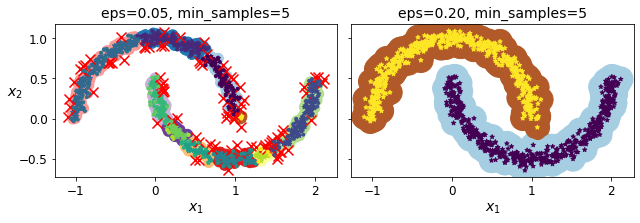

In [106]:
plt.figure(figsize=(9, 3.2))
plt.subplot(121)
plot_dbscan(dbscan, X, size=100)
plt.subplot(122)
plot_dbscan(dbscan2, X, size=600, show_ylabels=False)
save_fig("dbscan_plot")
plt.show()

In [107]:
dbscan = dbscan2

In [108]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=50, n_jobs=-1)
knn.fit(dbscan.components_, dbscan.labels_[dbscan.core_sample_indices_])

KNeighborsClassifier(n_jobs=-1, n_neighbors=50)

In [109]:
X_new = np.array([[-0.5, 0], [0, 0.5], [1, -0.1], [2, 1]])
knn.predict(X_new)

array([1, 0, 1, 0], dtype=int64)

In [110]:
knn.predict_proba(X_new)

array([[0.2 , 0.8 ],
       [1.  , 0.  ],
       [0.24, 0.76],
       [1.  , 0.  ]])

그림 저장: cluster_classification_plot


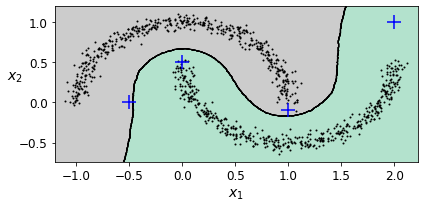

In [111]:
plt.figure(figsize=(6, 3))
plot_decision_boundaries(knn, X, show_centroids=False)
plt.scatter(X_new[:, 0], X_new[:, 1], c='b', marker='+', s=200, zorder=10)
save_fig("cluster_classification_plot")
plt.show()

In [112]:
y_dist, y_pred_idx = knn.kneighbors(X_new, n_neighbors=1)
y_pred = dbscan.labels_[dbscan.core_sample_indices_][y_pred_idx]
y_pred[y_dist > 0.2] = -1
y_pred.ravel()

array([-1,  0,  1, -1], dtype=int64)

## 다른 군집 알고리즘

### 스펙트럼 군집

In [113]:
from sklearn.cluster import SpectralClustering

sc1 = SpectralClustering(n_clusters=2, gamma=100, n_jobs=-1)
sc1.fit(X)

SpectralClustering(gamma=100, n_clusters=2, n_jobs=-1)

In [114]:
sc2 = SpectralClustering(n_clusters=2, n_jobs=-1)
sc2.fit(X)

SpectralClustering(n_clusters=2, n_jobs=-1)

In [115]:
np.percentile(sc1.affinity_matrix_, 95)

0.03980857949817387

In [116]:
def plot_spectral_clustering(sc, X, size, alpha, show_xlabels=True, show_ylabels=True):
    plt.scatter(X[:, 0], X[:, 1], marker='o', s=size, c="gray", cmap="Paired", alpha=alpha)
    plt.scatter(X[:, 0], X[:, 1], marker='o', s=30, c='w')
    plt.scatter(X[:, 0], X[:, 1], marker='.', s=10, c=sc.labels_, cmap="Paired")
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title(f"RBF gamma={sc.gamma}", fontsize=14)

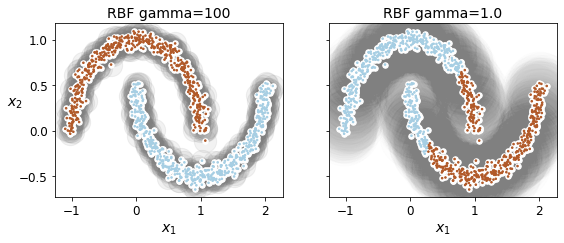

In [117]:
plt.figure(figsize=(9, 3.2))
plt.subplot(121)
plot_spectral_clustering(sc1, X, size=500, alpha=0.1)
plt.subplot(122)
plot_spectral_clustering(sc2, X, size=4000, alpha=0.01, show_ylabels=False)
plt.show()

### 병합 군집

In [118]:
from sklearn.cluster import AgglomerativeClustering

X = np.array([0, 2, 5, 8.5]).reshape(-1, 1)
agg = AgglomerativeClustering(linkage="complete").fit(X)

In [119]:
def learned_parameters(estimator):
    return [attrib for attrib in dir(estimator) if attrib.endswith('_') and not attrib.startswith('_')]

In [120]:
learned_parameters(agg)

['children_',
 'labels_',
 'n_clusters_',
 'n_connected_components_',
 'n_features_in_',
 'n_leaves_']

In [121]:
agg.children_

array([[0, 1],
       [2, 3],
       [4, 5]])

# 가우시안 혼합

In [122]:
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

이 데이터셋으로 가우시안 혼합 모델을 훈련해 본다:

In [123]:
from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components=3, n_init=10)
gm.fit(X)

GaussianMixture(n_components=3, n_init=10)

EM 알고리즘이 추정한 파라미터를 확인해 본다:

In [124]:
gm.weights_

array([0.40009697, 0.20925194, 0.39065109])

In [125]:
gm.means_

array([[-1.40745226,  1.42727761],
       [ 3.40241777,  1.05702687],
       [ 0.05292802,  0.07720061]])

In [126]:
gm.covariances_

array([[[ 0.63518782,  0.7300408 ],
        [ 0.7300408 ,  1.16123726]],

       [[ 1.14357415, -0.02922398],
        [-0.02922398,  0.95297095]],

       [[ 0.69052478,  0.79895376],
        [ 0.79895376,  1.21568342]]])

이 알고리즘이 실제로 수렴했을까?

In [127]:
gm.converged_

True

좋다. 몇 번 반복했을까?

In [128]:
gm.n_iter_

6

이제 이 모델을 사용해 각 샘플이 속한 클러스터(하드 군집)나 클러스터에 속할 확률을 예측할 수 있다. 이를 위해 `predict()` 메서드나 `predict_proba()` 메서드를 사용한다:

In [129]:
gm.predict(X)

array([2, 2, 0, ..., 1, 1, 1], dtype=int64)

In [130]:
gm.predict_proba(X)

array([[6.80542526e-07, 2.27284124e-02, 9.77270907e-01],
       [6.78281758e-04, 1.60398423e-02, 9.83281876e-01],
       [9.99922872e-01, 1.93447944e-06, 7.51931764e-05],
       ...,
       [2.19704604e-26, 9.99999561e-01, 4.39240952e-07],
       [1.52817376e-41, 1.00000000e+00, 5.39200212e-16],
       [8.29296554e-41, 1.00000000e+00, 2.33864674e-15]])

이 모델은 생성 모델이다. 따라서 새로운 샘플(과 레이블)을 생성할 수 있다:

In [131]:
X_new, y_new = gm.sample(6)
X_new

array([[-0.13514001,  2.17101884],
       [-1.39730352,  0.38989724],
       [-0.158415  ,  1.90405679],
       [ 0.08449342,  0.15915645],
       [-1.17887511, -1.24395343],
       [ 1.55076074,  2.90017133]])

In [132]:
y_new

array([0, 0, 0, 2, 2, 2])

각 클러스터에서 순서대로 샘플링되었다.

`score_samples()` 메서드를 사용해 로그 _확률 밀도 함수_ (PDF)를 추정할 수도 있다.

In [133]:
gm.score_samples(X)

array([-2.60562363, -3.57128156, -3.33045538, ..., -3.51403945,
       -4.39552047, -3.80518816])

전체 공간에 대해 이 PDF를 적분하면 1이 되는지 확인해 본다. 클러스터 주위로 큰 사각형을 정하고 작은 사각형의 그리드로 자른다. 그다음 작은 사각형에서 샘플이 생성될 확률의 근삿값을 계산해 본자(작은 사각형의 면적과 PDF를 곱하고 이 확률을 모두 더한다). 결괏값은 1에 가깝다:

In [134]:
resolution = 100
grid = np.arange(-10, 10, 1 / resolution)
xx, yy = np.meshgrid(grid, grid)
X_full = np.vstack([xx.ravel(), yy.ravel()]).T
pdf = np.exp(gm.score_samples(X_full))
pdf_probas = pdf * (1 / resolution) ** 2
pdf_probas.sum()

0.9999999999262454

만들어진 결정 경계(파선)와 밀도 등고선을 그려 본다:

In [135]:
from matplotlib.colors import LogNorm


def plot_gaussian_mixture(clusterer, X, resolution=1000, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution), np.linspace(mins[1], maxs[1], resolution))
    Z = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, norm=LogNorm(vmin=1.0, vmax=30.0), levels=np.logspace(0, 2, 12))
    plt.contour(xx, yy, Z, norm=LogNorm(vmin=1.0, vmax=30.0), levels=np.logspace(0, 2, 12), linewidths=1, colors='k')
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, linewidths=2, colors='r', linestyles="dashed")
    plt.plot(X[:, 0], X[:, 1], "k.", markersize=2)
    plot_centroids(clusterer.means_, clusterer.weights_)
    plt.xlabel("$x_1$", fontsize=14)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

그림 저장: gaussian_mixtures_plot


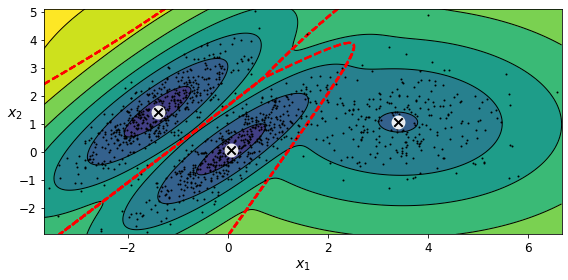

In [136]:
plt.figure(figsize=(8, 4))
plot_gaussian_mixture(gm, X)
save_fig("gaussian_mixtures_plot")
plt.show()

`covariance_type` 매개변수를 사용해 이 알고리즘이 찾을 공분산 행렬을 제한할 수 있다.
* `"full"`(기본값): 제약이 없다. 모든 클러스터가 어떤 크기의 타원도 될 수 있다.
* `"tied"`: 모든 클러스터가 동일하지만 어떤 타원도 가능하다(즉, 공분산 행렬을 공유한다).
* `"spherical"`: 모든 클러스터가 원형이지만 지름은 다를 수 있다(즉, 분산이 다르다).
* `"diag"`: 클러스터는 어떤 크기의 타원도 될 수 있지만 타원은 축에 나란해야 한다(즉, 공분산 행렬이 대각 행렬이다).

In [137]:
gm_full = GaussianMixture(n_components=3, n_init=10)
gm_tied = GaussianMixture(n_components=3, n_init=10, covariance_type="tied")
gm_spherical = GaussianMixture(n_components=3, n_init=10, covariance_type="spherical")
gm_diag = GaussianMixture(n_components=3, n_init=10, covariance_type="diag")
gm_full.fit(X)
gm_tied.fit(X)
gm_spherical.fit(X)
gm_diag.fit(X)

GaussianMixture(covariance_type='diag', n_components=3, n_init=10)

In [138]:
def compare_gaussian_mixtures(gm1, gm2, X):
    plt.figure(figsize=(9, 4))
    plt.subplot(121)
    plot_gaussian_mixture(gm1, X)
    plt.title(f'covariance_type="{gm1.covariance_type}"', fontsize=14)
    plt.subplot(122)
    plot_gaussian_mixture(gm2, X, show_ylabels=False)
    plt.title(f'covariance_type="{gm2.covariance_type}"', fontsize=14)

그림 저장: covariance_type_plot


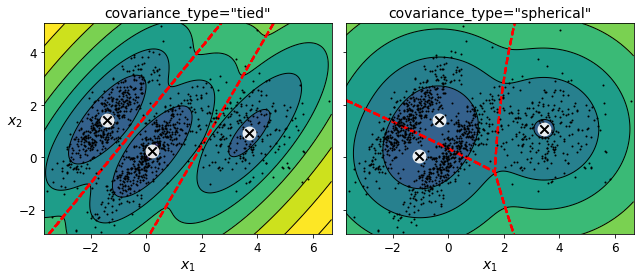

In [139]:
compare_gaussian_mixtures(gm_tied, gm_spherical, X)
save_fig("covariance_type_plot")
plt.show()

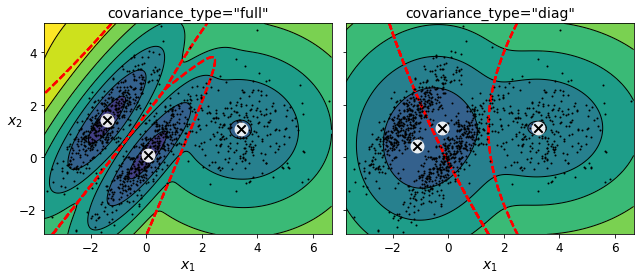

In [140]:
compare_gaussian_mixtures(gm_full, gm_diag, X)
plt.tight_layout()
plt.show()

사이킷런 예제:
![scikit-learn-docs](https://scikit-learn.org/stable/_images/sphx_glr_plot_gmm_covariances_001.png)

## 가우시안 혼합을 사용한 이상치 탐지

가우시안 혼합을 _이상치 탐지_ 에 사용할 수 있다: 밀도가 낮은 지역에 있는 샘플을 이상치로 생각할 수 있다. 사용할 밀도 임곗값을 결정해야 한다. 예를 들어 한 제조 회사에서 결함 제품을 감지하려고 한다. 결함 제품의 비율은 잘 알려져 있다. 이 비율이 4%라고 하면 밀도 임곗값을 이 값으로 지정하여 임계 밀도보다 낮은 지역에 있는 샘플을 얻을 수 있다:

In [141]:
densities = gm.score_samples(X)
density_threshold = np.percentile(densities, 4)
anomalies = X[densities < density_threshold]

그림 저장: mixture_anomaly_detection_plot


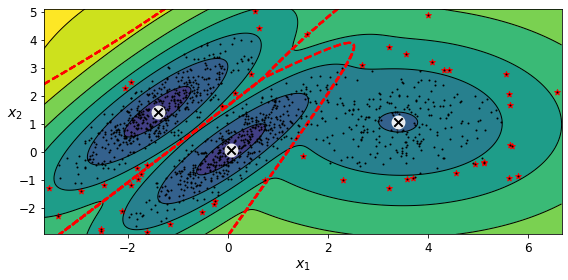

In [142]:
plt.figure(figsize=(8, 4))
plot_gaussian_mixture(gm, X)
plt.scatter(anomalies[:, 0], anomalies[:, 1], color='r', marker='*')
save_fig("mixture_anomaly_detection_plot")
plt.show()

## 모델 선택

이너셔나 실루엣 점수는 모두 원형 클러스터를 가정하기 때문에 가우시안 혼합 모델에 사용할 수 없다. 대신 BIC(Bayesian Information Criterion)나 AIC(Akaike Information Criterion) 같은 이론적 정보 기준을 최소화하는 모델을 찾을 수 있다:

${BIC} = {\log(m)p - 2\log({\hat L})}$

${AIC} = 2p - 2\log(\hat L)$

* $m$은 샘플의 개수이다.
* $p$는 모델이 학습할 파라미터 개수이다.
* $\hat L$은 모델의 가능도 함수의 최댓값이다. 이는 모델과 최적의 파라미터가 주어졌을 때 관측 데이터 $\mathbf{X}$의 조건부 확률이다.

BIC와 AIC 모두 모델이 많은 파라미터(예를 들면 많은 클러스터)를 학습하지 못하도록 제한한다. 그리고 데이터에 잘 맞는 모델(즉, 관측 데이터에 가능도가 높은 모델)에 보상을 준다.

In [143]:
gm.bic(X)

8189.631185845492

In [144]:
gm.aic(X)

8102.405905730454

다음과 같이 BIC를 수동으로 계산할 수 있다:

In [145]:
n_clusters = 3
n_dims = 2
n_params_for_weights = n_clusters - 1
n_params_for_means = n_clusters * n_dims
n_params_for_covariance = n_clusters * n_dims * (n_dims + 1) // 2
n_params = n_params_for_weights + n_params_for_means + n_params_for_covariance
max_log_likelihood = gm.score(X) * len(X)  # log(L^)
bic = np.log(len(X)) * n_params - 2 * max_log_likelihood
aic = 2 * n_params - 2 * max_log_likelihood

In [146]:
bic, aic

(8189.631185845492, 8102.405905730454)

In [147]:
n_params

17

클러스터마다 하나의 가중치가 있지만 모두 더하면 1이 되어야 한다. 따라서 자유도는 1이 줄어든다. 비슷하게 $n \times n$ 공분산 행렬의 자유도는 $n^2$가 아니라 $1 + 2 + \dots + n = \dfrac{n (n+1)}{2}$이다.

여러 가지 $k$ 값에 대해 가우시안 혼합 모델을 훈련하고 BIC를 측정해 본다:

In [148]:
gms_per_k = [GaussianMixture(n_components=k, n_init=10).fit(X) for k in range(1, 11)]

In [149]:
bics = [model.bic(X) for model in gms_per_k]
aics = [model.aic(X) for model in gms_per_k]

그림 저장: aic_bic_vs_k_plot


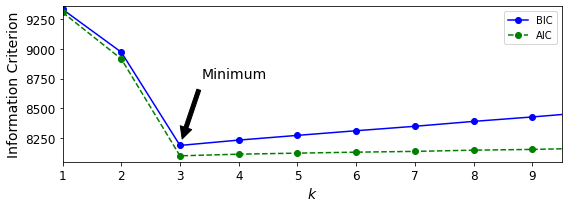

In [150]:
plt.figure(figsize=(8, 3))
plt.plot(range(1, 11), bics, "bo-", label="BIC")
plt.plot(range(1, 11), aics, "go--", label="AIC")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Information Criterion", fontsize=14)
plt.axis([1, 9.5, np.min(aics) - 50, np.max(aics) + 50])
plt.annotate(
    "Minimum",
    xy=(3, bics[2]),
    xytext=(0.35, 0.6),
    textcoords="figure fraction",
    fontsize=14,
    arrowprops=dict(facecolor="black", shrink=0.1)
)
plt.legend()
save_fig("aic_bic_vs_k_plot")
plt.show()

클러스터 개수와 `covariance_type` 하이퍼파라미터의 최적 조합을 찾아본다:

In [151]:
min_bic = np.infty
for k in range(1, 11):
    for covariance_type in ("full", "tied", "spherical", "diag"):
        bic = GaussianMixture(n_components=k, n_init=10, covariance_type=covariance_type).fit(X).bic(X)
        if bic < min_bic:
            min_bic = bic
            best_k = k
            best_covariance_type = covariance_type

In [152]:
best_k

3

In [153]:
best_covariance_type

'full'

## 베이즈 가우시안 혼합 모델

최적의 클러스터 개수를 수동으로 찾는 대신 `BayesianGaussianMixture` 클래스를 사용해 불필요한 클러스터의 가중치를 0으로 (또는 0에 가깝게) 만들 수 있다. 최적의 클러스터 개수보다 큰 컴포넌트의 개수를 지정하면 된다. 이 알고리즘은 자동으로 불필요한 클러스터를 제거한다:

In [154]:
from sklearn.mixture import BayesianGaussianMixture

bgm = BayesianGaussianMixture(n_components=10, n_init=10)
bgm.fit(X)

BayesianGaussianMixture(n_components=10, n_init=10)

알고리즘이 자동으로 3개의 컴포넌트가 필요하다는 것을 감지했다:

In [155]:
np.round(bgm.weights_, 2)

array([0.2 , 0.4 , 0.  , 0.  , 0.39, 0.  , 0.  , 0.  , 0.  , 0.  ])

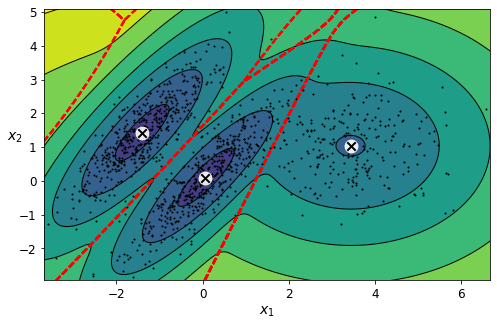

In [156]:
plt.figure(figsize=(8, 5))
plot_gaussian_mixture(bgm, X)
plt.show()

In [157]:
bgm_low = BayesianGaussianMixture(n_components=10, max_iter=1000, weight_concentration_prior=0.01, random_state=42)
bgm_high = BayesianGaussianMixture(n_components=10, max_iter=1000, weight_concentration_prior=10000, random_state=42)
nn = 73
bgm_low.fit(X[:nn])
bgm_high.fit(X[:nn])

BayesianGaussianMixture(max_iter=1000, n_components=10, random_state=42,
                        weight_concentration_prior=10000)

In [158]:
np.round(bgm_low.weights_, 2)

array([0.52, 0.48, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

In [159]:
np.round(bgm_high.weights_, 2)

array([0.01, 0.18, 0.27, 0.11, 0.01, 0.01, 0.01, 0.01, 0.37, 0.01])

그림 저장: mixture_concentration_prior_plot


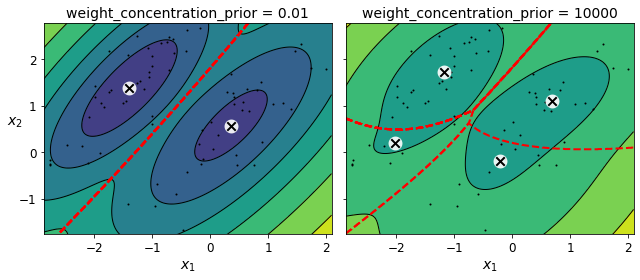

In [160]:
plt.figure(figsize=(9, 4))
plt.subplot(121)
plot_gaussian_mixture(bgm_low, X[:nn])
plt.title("weight_concentration_prior = 0.01", fontsize=14)
plt.subplot(122)
plot_gaussian_mixture(bgm_high, X[:nn], show_ylabels=False)
plt.title("weight_concentration_prior = 10000", fontsize=14)
save_fig("mixture_concentration_prior_plot")
plt.show()

In [161]:
X_moons, y_moons = make_moons(n_samples=1000, noise=0.05)

In [162]:
bgm = BayesianGaussianMixture(n_components=10, n_init=70)
bgm.fit(X_moons)

BayesianGaussianMixture(n_components=10, n_init=70)

그림 저장: moons_vs_bgm_plot


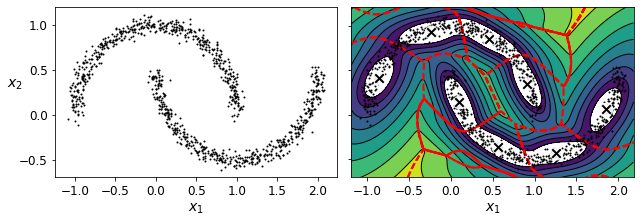

In [163]:
plt.figure(figsize=(9, 3.2))
plt.subplot(121)
plot_data(X_moons)
plt.xlabel("$x_1$", fontsize=14)
plt.ylabel("$x_2$", fontsize=14, rotation=0)
plt.subplot(122)
plot_gaussian_mixture(bgm, X_moons, show_ylabels=False)
save_fig("moons_vs_bgm_plot")
plt.show()

이런 좋지 않다. 반달 모양 클러스터 2개를 감지하는 대신 이 알고리즘은 더 많은 타원 클러스터를 감지했다. 하지만 밀도 그래프는 그렇게 나쁘지 않기 때문에 이상치 탐지에 사용할 수 있다.

**가능도 함수**

In [164]:
from scipy.stats import norm

xx = np.linspace(-6, 4, 101)
ss = np.linspace(1, 2, 101)
XX, SS = np.meshgrid(xx, ss)
ZZ = 2 * norm.pdf(XX - 1.0, 0, SS) + norm.pdf(XX + 4.0, 0, SS)
ZZ = ZZ / ZZ.sum(axis=1)[:, np.newaxis] / (xx[1] - xx[0])

그림 저장: likelihood_function_plot


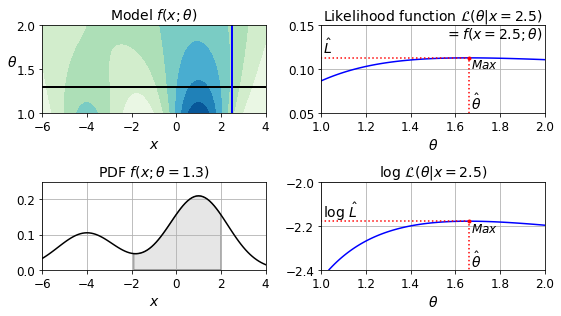

In [165]:
from matplotlib.patches import Polygon

plt.figure(figsize=(8, 4.5))
x_idx = 85
s_idx = 30
plt.subplot(221)
plt.contourf(XX, SS, ZZ, cmap="GnBu")
plt.plot([-6, 4], [ss[s_idx], ss[s_idx]], "k-", linewidth=2)
plt.plot([xx[x_idx], xx[x_idx]], [1, 2], "b-", linewidth=2)
plt.xlabel(r"$x$")
plt.ylabel(r"$\theta$", fontsize=14, rotation=0)
plt.title(r"Model $f(x; \theta)$", fontsize=14)
plt.subplot(222)
plt.plot(ss, ZZ[:, x_idx], "b-")
max_idx = np.argmax(ZZ[:, x_idx])
max_val = np.max(ZZ[:, x_idx])
plt.plot(ss[max_idx], max_val, "r.")
plt.plot([ss[max_idx], ss[max_idx]], [0, max_val], "r:")
plt.plot([0, ss[max_idx]], [max_val, max_val], "r:")
plt.text(1.01, max_val + 0.005, r"$\hat{L}$", fontsize=14)
plt.text(ss[max_idx] + 0.01, 0.055, r"$\hat{\theta}$", fontsize=14)
plt.text(ss[max_idx] + 0.01, max_val - 0.012, r"$Max$", fontsize=12)
plt.axis([1, 2, 0.05, 0.15])
plt.xlabel(r"$\theta$", fontsize=14)
plt.grid(True)
plt.text(1.99, 0.135, r"$=f(x=2.5; \theta)$", fontsize=14, ha="right")
plt.title(r"Likelihood function $\mathcal{L}(\theta|x=2.5)$", fontsize=14)
plt.subplot(223)
plt.plot(xx, ZZ[s_idx], "k-")
plt.axis([-6, 4, 0, 0.25])
plt.xlabel(r"$x$", fontsize=14)
plt.grid(True)
plt.title(r"PDF $f(x; \theta=1.3)$", fontsize=14)
verts = [(xx[41], 0)] + list(zip(xx[41:81], ZZ[s_idx, 41:81])) + [(xx[80], 0)]
poly = Polygon(verts, facecolor="0.9", edgecolor="0.5")
plt.gca().add_patch(poly)
plt.subplot(224)
plt.plot(ss, np.log(ZZ[:, x_idx]), "b-")
max_idx = np.argmax(np.log(ZZ[:, x_idx]))
max_val = np.max(np.log(ZZ[:, x_idx]))
plt.plot(ss[max_idx], max_val, "r.")
plt.plot([ss[max_idx], ss[max_idx]], [-5, max_val], "r:")
plt.plot([0, ss[max_idx]], [max_val, max_val], "r:")
plt.axis([1, 2, -2.4, -2])
plt.xlabel(r"$\theta$", fontsize=14)
plt.text(ss[max_idx] + 0.01, max_val - 0.05, r"$Max$", fontsize=12)
plt.text(ss[max_idx] + 0.01, -2.39, r"$\hat{\theta}$", fontsize=14)
plt.text(1.01, max_val + 0.02, r"$\log \, \hat{L}$", fontsize=14)
plt.grid(True)
plt.title(r"$\log \, \mathcal{L}(\theta|x=2.5)$", fontsize=14)
save_fig("likelihood_function_plot")
plt.show()

# 연습

## 1. 올리베타 얼굴 데이터셋 군집하기

*전통적인 올리베티 얼굴 데이터셋은 64×64 픽셀 크기의 흑백 얼굴 이미지 400개를 담고 있다. 각 이미지는 4,096 크기의 1D 벡터로 펼쳐져 있다. 사람 40명의 사진을 10장씩 찍은 것이다. 어떤 사람의 사진인지 예측하는 모델을 훈련하는 것이 일반적이다. sklearn.datasets.fetch_olivetti_faces() 함수를 사용해 데이터셋을 불러온다.*

In [166]:
from sklearn.datasets import fetch_olivetti_faces

olivetti = fetch_olivetti_faces()

In [167]:
print(olivetti.DESCR)

.. _olivetti_faces_dataset:

The Olivetti faces dataset
--------------------------

`This dataset contains a set of face images`_ taken between April 1992 and 
April 1994 at AT&T Laboratories Cambridge. The
:func:`sklearn.datasets.fetch_olivetti_faces` function is the data
fetching / caching function that downloads the data
archive from AT&T.

.. _This dataset contains a set of face images: https://cam-orl.co.uk/facedatabase.html

As described on the original website:

    There are ten different images of each of 40 distinct subjects. For some
    subjects, the images were taken at different times, varying the lighting,
    facial expressions (open / closed eyes, smiling / not smiling) and facial
    details (glasses / no glasses). All the images were taken against a dark
    homogeneous background with the subjects in an upright, frontal position 
    (with tolerance for some side movement).

**Data Set Characteristics:**

    =================   =====================
    Classes    

In [168]:
olivetti.target

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13,
       13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15,
       15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18,
       18, 18, 18, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 20, 20, 20, 20,
       20, 20, 20, 20, 20, 20, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 22,
       22, 22, 22, 22, 22

*데이터셋을 훈련 세트, 검증 세트, 테스트 세트로 나눈다(이 데이터셋은 이미 0에서 1 사이로 스케일이 조정되어 있다). 이 데이터셋은 매우 작으니 계층적 샘플링을 사용해 각 세트에 동일한 사람의 얼굴이 고루 섞이도록 하는 것이 좋다.*

In [169]:
from sklearn.model_selection import StratifiedShuffleSplit

strat_split = StratifiedShuffleSplit(n_splits=1, test_size=40)
train_valid_idx, test_idx = next(strat_split.split(olivetti.data, olivetti.target))
X_train_valid = olivetti.data[train_valid_idx]
y_train_valid = olivetti.target[train_valid_idx]
X_test = olivetti.data[test_idx]
y_test = olivetti.target[test_idx]
strat_split = StratifiedShuffleSplit(n_splits=1, test_size=80)
train_idx, valid_idx = next(strat_split.split(X_train_valid, y_train_valid))
X_train = X_train_valid[train_idx]
y_train = y_train_valid[train_idx]
X_valid = X_train_valid[valid_idx]
y_valid = y_train_valid[valid_idx]

In [170]:
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

(280, 4096) (280,)
(80, 4096) (80,)
(40, 4096) (40,)


속도를 높이기 위해 PCA로 데이터의 차원을 줄인다:

In [171]:
from sklearn.decomposition import PCA

pca = PCA(0.99)
X_train_pca = pca.fit_transform(X_train)
X_valid_pca = pca.transform(X_valid)
X_test_pca = pca.transform(X_test)
pca.n_components_

200

*그다음 k-평균을 사용해 이미지를 군집해 본다. 적절한 클러스터 개수를 찾아본다.*

In [172]:
k_range = range(5, 150, 5)
kmeans_per_k = []
for k in k_range:
    print(f"k={k}")
    kmeans = KMeans(n_clusters=k).fit(X_train_pca)
    kmeans_per_k.append(kmeans)

k=5
k=10
k=15
k=20
k=25
k=30
k=35
k=40
k=45
k=50
k=55
k=60
k=65
k=70
k=75
k=80
k=85
k=90
k=95
k=100
k=105
k=110
k=115
k=120
k=125
k=130
k=135
k=140
k=145


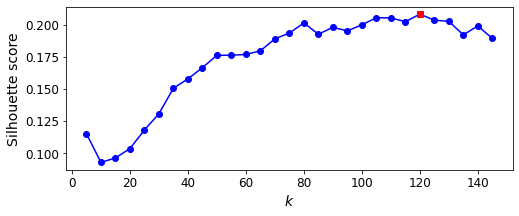

In [173]:
silhouette_scores = [silhouette_score(X_train_pca, model.labels_) for model in kmeans_per_k]
best_index = np.argmax(silhouette_scores)
best_k = k_range[best_index]
best_score = silhouette_scores[best_index]
plt.figure(figsize=(8, 3))
plt.plot(k_range, silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.plot(best_k, best_score, "rs")
plt.show()

In [174]:
best_k

120

최적의 클러스터 개수가 매우 크다. 사진 속의 인물이 40명이기 때문에 40 정도로 예상했다. 하지만 같은 사람이 사진마다 다르게 보일 수 있다(예를 들어, 안경 착용 유무나 서 있는 방향이 다를 수 있다).

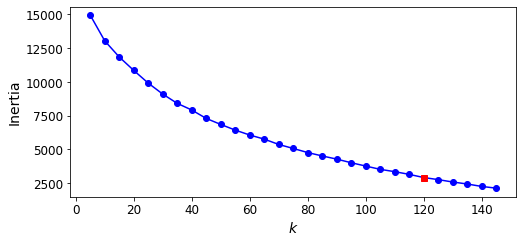

In [175]:
inertias = [model.inertia_ for model in kmeans_per_k]
best_inertia = inertias[best_index]
plt.figure(figsize=(8, 3.5))
plt.plot(k_range, inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.plot(best_k, best_inertia, "rs")
plt.show()

이너셔 그래프에서는 엘보우 지점이 없기 때문에 최적의 클러스터 개수가 명확하지 않다. 그냥 앞서 구한 $k$ 개수를 사용하겠다.

In [176]:
best_model = kmeans_per_k[best_index]

*클러스터를 시각화해 본다. 각 클러스터에 비슷한 얼굴이 들어 있을까?*

Cluster 0


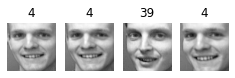

Cluster 1


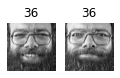

Cluster 2


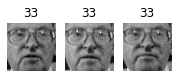

Cluster 3


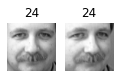

Cluster 4


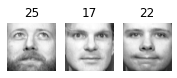

Cluster 5


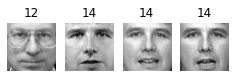

Cluster 6


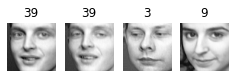

Cluster 7


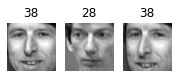

Cluster 8


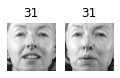

Cluster 9


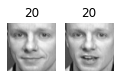

Cluster 10


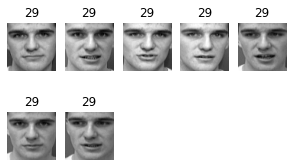

Cluster 11


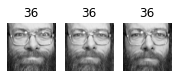

Cluster 12


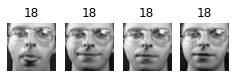

Cluster 13


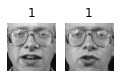

Cluster 14


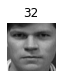

Cluster 15


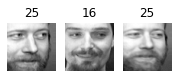

Cluster 16


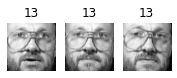

Cluster 17


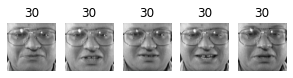

Cluster 18


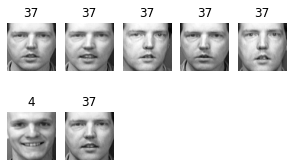

Cluster 19


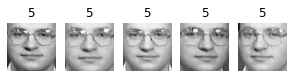

Cluster 20


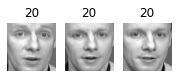

Cluster 21


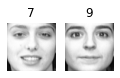

Cluster 22


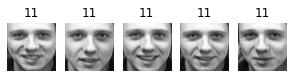

Cluster 23


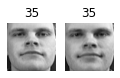

Cluster 24


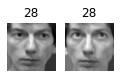

Cluster 25


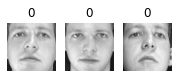

Cluster 26


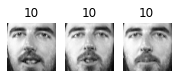

Cluster 27


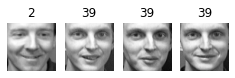

Cluster 28


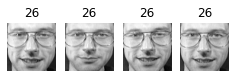

Cluster 29


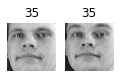

Cluster 30


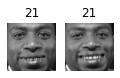

Cluster 31


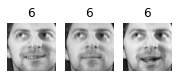

Cluster 32


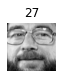

Cluster 33


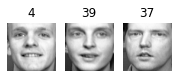

Cluster 34


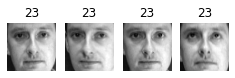

Cluster 35


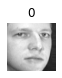

Cluster 36


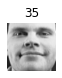

Cluster 37


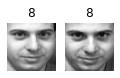

Cluster 38


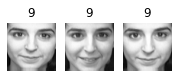

Cluster 39


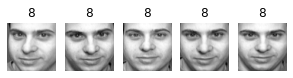

Cluster 40


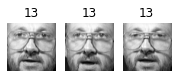

Cluster 41


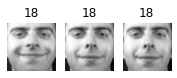

Cluster 42


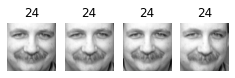

Cluster 43


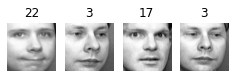

Cluster 44


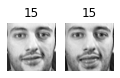

Cluster 45


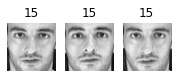

Cluster 46


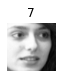

Cluster 47


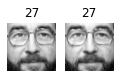

Cluster 48


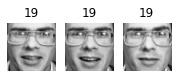

Cluster 49


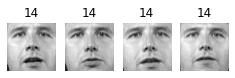

Cluster 50


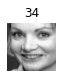

Cluster 51


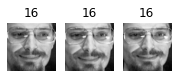

Cluster 52


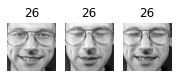

Cluster 53


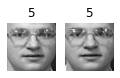

Cluster 54


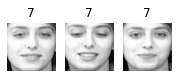

Cluster 55


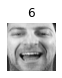

Cluster 56


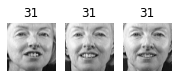

Cluster 57


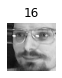

Cluster 58


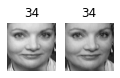

Cluster 59


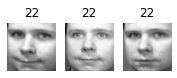

Cluster 60


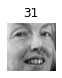

Cluster 61


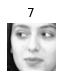

Cluster 62


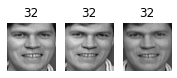

Cluster 63


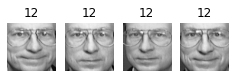

Cluster 64


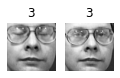

Cluster 65


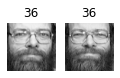

Cluster 66


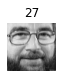

Cluster 67


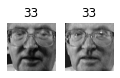

Cluster 68


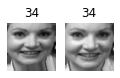

Cluster 69


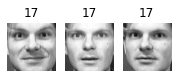

Cluster 70


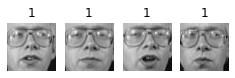

Cluster 71


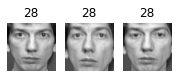

Cluster 72


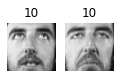

Cluster 73


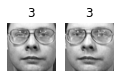

Cluster 74


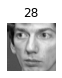

Cluster 75


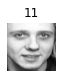

Cluster 76


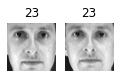

Cluster 77


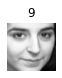

Cluster 78


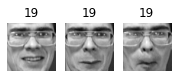

Cluster 79


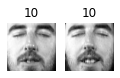

Cluster 80


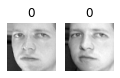

Cluster 81


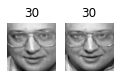

Cluster 82


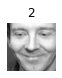

Cluster 83


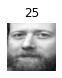

Cluster 84


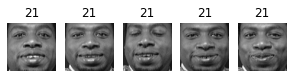

Cluster 85


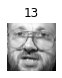

Cluster 86


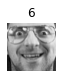

Cluster 87


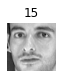

Cluster 88


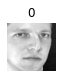

Cluster 89


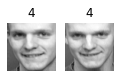

Cluster 90


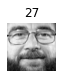

Cluster 91


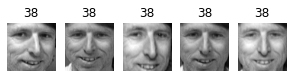

Cluster 92


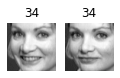

Cluster 93


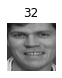

Cluster 94


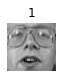

Cluster 95


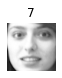

Cluster 96


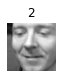

Cluster 97


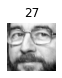

Cluster 98


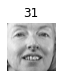

Cluster 99


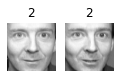

Cluster 100


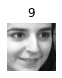

Cluster 101


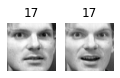

Cluster 102


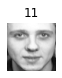

Cluster 103


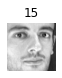

Cluster 104


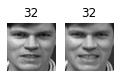

Cluster 105


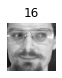

Cluster 106


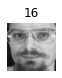

Cluster 107


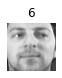

Cluster 108


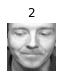

Cluster 109


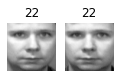

Cluster 110


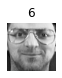

Cluster 111


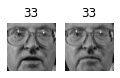

Cluster 112


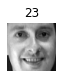

Cluster 113


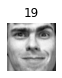

Cluster 114


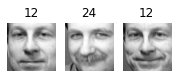

Cluster 115


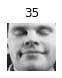

Cluster 116


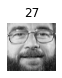

Cluster 117


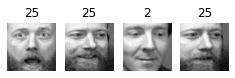

Cluster 118


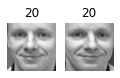

Cluster 119


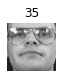

In [177]:
def plot_faces(faces, labels, n_cols=5):
    faces = faces.reshape(-1, 64, 64)
    n_rows = (len(faces) - 1) // n_cols + 1
    plt.figure(figsize=(n_cols, n_rows + 1))
    for index, (face, label) in enumerate(zip(faces, labels)):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(face, cmap="gray")
        plt.axis("off")
        plt.title(label)
    plt.show()


for cluster_id in np.unique(best_model.labels_):
    print(f"Cluster {cluster_id}")
    in_cluster = best_model.labels_ == cluster_id
    faces = X_train[in_cluster]
    labels = y_train[in_cluster]
    plot_faces(faces, labels)

약 2/3 정도가 쓸모있어 보인다. 즉 적어도 2개의 사진을 가지고 있고 모두 동일한 사람이다. 하지만 나머지 클러스터는 다른 사람 얼굴이 하나 이상 있거나 하나의 사진만 가지고 있다.

이런 방식으로 군집된 이미지는 부정확해서 (아래에서 보겠지만) 모델을 훈련할 때 바로 사용하기 어렵다. 하지만 새로운 데이터셋에 이미지를 레이블링할 때는 매우 유용할 수 있다. 일반적으로 훨씬 빠르게 레이블을 부여할 수 있다.

## 2. 분류를 위해 군집으로 전처리하기

*올리베티 얼굴 데이터셋으로 계속한다. 사진에 나타난 사람을 예측하는 분류기를 훈련하고 검증 세트에서 평가한다.*

In [178]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=150, n_jobs=-1)
clf.fit(X_train_pca, y_train)
clf.score(X_valid_pca, y_valid)

0.975

*그다음 k-평균을 차원 축소 도구로 사용하여 축소된 세트에서 분류기를 훈련한다.*

In [179]:
X_train_reduced = best_model.transform(X_train_pca)
X_valid_reduced = best_model.transform(X_valid_pca)
X_test_reduced = best_model.transform(X_test_pca)
clf = RandomForestClassifier(n_estimators=150, n_jobs=-1)
clf.fit(X_train_reduced, y_train)
clf.score(X_valid_reduced, y_valid)

0.8125

전혀 좋아지지 않다! 클러스터 개수를 튜닝하면 도움이 되는지 알아 본다.

*분류기 성능을 최대로 만드는 클러스터 개수를 찾아보자. 얼마나 성능이 나올까?*

앞에서처럼 `GridSearchCV`를 사용할 수 있다. 하지만 검증 세트가 이미 있기 때문에 K-폴드 교차 검증을 할 필요가 없고 하나의 하이퍼파라미터만 탐색하기 때문에 간단히 직접 반복문을 만들겠다:

In [180]:
for n_clusters in k_range:
    pipeline = Pipeline(
        [("kmeans", KMeans(n_clusters=n_clusters)), ("forest_clf", RandomForestClassifier(n_estimators=150, n_jobs=-1))]
    )
    pipeline.fit(X_train_pca, y_train)
    print(f"{n_clusters} {pipeline.score(X_valid_pca, y_valid)}")

5 0.4
10 0.4875
15 0.575
20 0.625
25 0.7
30 0.725
35 0.7
40 0.7375
45 0.7375
50 0.7375
55 0.775
60 0.75
65 0.7625
70 0.7625
75 0.775
80 0.75
85 0.8125
90 0.7875
95 0.75
100 0.825
105 0.775
110 0.75
115 0.7625
120 0.775
125 0.7625
130 0.7875
135 0.775
140 0.775
145 0.8


클러스터 개수를 튜닝해도 높은 정확도를 내지 못한다. 클러스터 센트로이드까지 거리는 원본 이미지만큼 유용하지 않은 것 같다.

*축소된 세트에서 추출한 특성을 원본 특성에 추가하면 어떨까? (여기에서도 최선의 클러스터 개수를 찾아보자.)*

In [181]:
X_train_extended = np.c_[X_train_pca, X_train_reduced]
X_valid_extended = np.c_[X_valid_pca, X_valid_reduced]
X_test_extended = np.c_[X_test_pca, X_test_reduced]

In [182]:
clf = RandomForestClassifier(n_estimators=150, n_jobs=-1)
clf.fit(X_train_extended, y_train)
clf.score(X_valid_extended, y_valid)

0.8625

조금 나아졌다. 하지만 클러스터 특성이 없는 것이 차라리 낫다. 이 경우 클러스터는 분류기를 직접 훈련하는데 도움이 되지 않는다(하지만 새로운 훈련 샘플을 레이블링하는데는 여전히 도움이 될 수 있다).

## 3. 올리베티 얼굴 데이터셋을 위한 가우시안 혼합 모델

*올리베티 얼굴 데이터셋에서 가우시안 혼합 모델을 훈련해 보자. 알고리즘의 속도를 높이기 위해 데이터셋의 차원을 감소시켜야 한다(분산의 99%를 유지하면서 PCA를 사용한다).*

In [183]:
gm = GaussianMixture(n_components=40)
y_pred = gm.fit_predict(X_train_pca)

*이 모델을 사용해 (`sample()` 메서드로) 새로운 얼굴을 생성하고 시각화해 본다(PCA는 `inverse_transform()` 메서드를 사용해야 한다).*

In [184]:
n_gen_faces = 20
gen_faces_reduced, y_gen_faces = gm.sample(n_samples=n_gen_faces)
gen_faces = pca.inverse_transform(gen_faces_reduced)

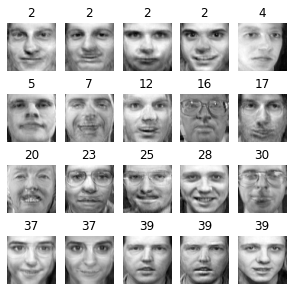

In [185]:
plot_faces(gen_faces, y_gen_faces)

*일부 이미지를 수정해 보자(회전, 뒤집기, 어둡게 하기). 모델이 이상치를 감지하는지 확인해 본다(즉 정상 샘플과 이상치에 대해 `score_samples()` 메서드 출력을 비교해 본다).*

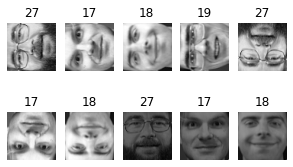

In [186]:
n_rotated = 4
rotated = np.transpose(X_train[:n_rotated].reshape(-1, 64, 64), axes=[0, 2, 1])
rotated = rotated.reshape(-1, 64 * 64)
y_rotated = y_train[:n_rotated]
n_flipped = 3
flipped = X_train[:n_flipped].reshape(-1, 64, 64)[:, ::-1]
flipped = flipped.reshape(-1, 64 * 64)
y_flipped = y_train[:n_flipped]
n_darkened = 3
darkened = X_train[:n_darkened].copy()
darkened[:, 1:-1] *= 0.3
y_darkened = y_train[:n_darkened]
X_bad_faces = np.r_[rotated, flipped, darkened]
y_bad = np.concatenate([y_rotated, y_flipped, y_darkened])
plot_faces(X_bad_faces, y_bad)

In [187]:
X_bad_faces_pca = pca.transform(X_bad_faces)

In [188]:
gm.score_samples(X_bad_faces_pca)

array([-29549277.80420607, -34450962.490265  , -25890307.88929729,
       -29670381.01083096, -50576929.51862525, -31034509.29351728,
       -45749784.56353768, -76627960.1996731 , -65020916.22833896,
       -64118641.73418089])

잘못된 사진은 이 가우시안 혼합 모델에서 등장할 가능성이 매우 낮다. 다른 훈련 샘플의 점수와 비교해 본다:

In [189]:
gm.score_samples(X_train_pca[:10])

array([1145.9914456 , 1131.81763424, 1124.4679712 , 1103.71883466,
       1146.01639459, 1148.2648938 , 1136.73888752, 1103.71883509,
       1137.89041718, 1147.17444961])

## 4. 차원 축소 기법을 사용해 이상치 탐지하기

*일부 차원 축소 기법은 이상치 탐지를 위해서 사용할 수도 있다. 올리베티 얼굴 데이터셋을 PCA를 사용해 분산의 99% 유지하도록 축소해 본다. 그다음 각 이미지의 재구성 오차를 계산한다. 그다음 이전 연습에서 만든 수정된 이미지를 선택해 재구성 오차를 확인해 본다. 재구성 오차가 얼마나 커지는지 확인한다. 재구성 이미지를 출력해 보면 이유를 알 수 있다. 정상 얼굴을 재구성하기 때문이다.*

이미 PCA를 사용해 축소된 데이터셋을 가지고 있다:

In [190]:
X_train_pca

array([[ 0.7327039 , -2.5619855 ,  1.2531495 , ...,  0.0214728 ,
        -0.03932748, -0.01684736],
       [-3.6765122 ,  0.39013115, -0.68498355, ..., -0.10722751,
        -0.20005439, -0.04788335],
       [-3.4236674 , -3.8078923 , -1.9436071 , ..., -0.05479644,
        -0.00793055,  0.17710154],
       ...,
       [ 1.1857785 ,  7.233468  , -3.9369822 , ...,  0.14457248,
         0.25835398,  0.03055253],
       [-2.2259064 ,  1.6292546 ,  1.1076411 , ...,  0.22789554,
         0.11354133,  0.01118219],
       [ 1.2618085 , -3.454175  ,  2.8257334 , ...,  0.03865485,
        -0.22748123, -0.09661528]], dtype=float32)

In [191]:
def reconstruction_errors(pca, X):
    X_pca = pca.transform(X)
    X_reconstructed = pca.inverse_transform(X_pca)
    mse = np.square(X_reconstructed - X).mean(axis=-1)
    return mse

In [192]:
reconstruction_errors(pca, X_train).mean()

0.00019026619

In [193]:
reconstruction_errors(pca, X_bad_faces).mean()

0.0062367683

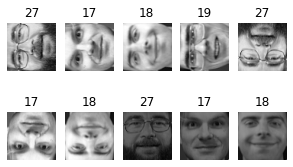

In [194]:
plot_faces(X_bad_faces, y_bad)

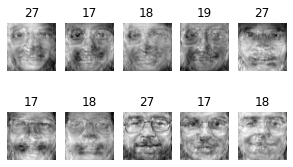

In [195]:
X_bad_faces_reconstructed = pca.inverse_transform(X_bad_faces_pca)
plot_faces(X_bad_faces_reconstructed, y_bad)